In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix


2025-08-03 07:10:49.121666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754205049.472677      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754205049.569103      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
import pandas as pd

# Load the CSV
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

# Convert one-hot encoded labels into a single 'label' column
class_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df['label'] = df[class_columns].idxmax(axis=1)

# Append .jpg extension to image IDs if needed
df['image_id'] = df['image_id'].apply(lambda x: x + '.jpg')

# Preview
print(df.head())
print("\nLabel distribution:\n", df['label'].value_counts())

df.shape

      image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0.jpg        0                  0     0     1               scab
1  Train_1.jpg        0                  1     0     0  multiple_diseases
2  Train_2.jpg        1                  0     0     0            healthy
3  Train_3.jpg        0                  0     1     0               rust
4  Train_4.jpg        1                  0     0     0            healthy

Label distribution:
 label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64


(1821, 6)

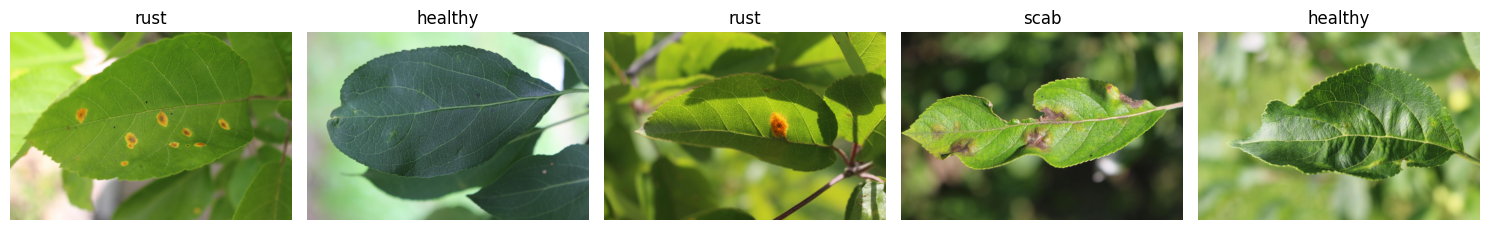

In [9]:
import matplotlib.pyplot as plt
import cv2

img_path = "/kaggle/input/plant-pathology-2020-fgvc7/images/"  # note the ending slash
sample = df.sample(5)

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample.itertuples(), 1):
    img = cv2.imread(img_path + row.image_id)  # NO extra '.jpg'
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
img_size = 224
batch_size = 32

# Create train/val split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# Data generators
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20,
                             zoom_range=0.2,
                             horizontal_flip=True)

train_gen = datagen.flow_from_dataframe(
    train_df,
    directory=img_path,
    x_col='image_id',
    y_col='label',
    target_size=(img_size, img_size),
    class_mode='categorical',
    batch_size=batch_size
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    directory=img_path,
    x_col='image_id',
    y_col='label',
    target_size=(img_size, img_size),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 1456 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(train_gen.class_indices), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
history = model.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1754205548.406287     110 service.cc:148] XLA service 0x7a411004ddd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754205548.408046     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754205548.408060     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754205550.099102     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/46 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.1250 - loss: 1.9800  

I0000 00:00:1754205555.814557     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2905 - loss: 1.4619 - val_accuracy: 0.3890 - val_loss: 1.2378
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 856ms/step - accuracy: 0.3357 - loss: 1.2589 - val_accuracy: 0.3671 - val_loss: 1.2309
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 853ms/step - accuracy: 0.3607 - loss: 1.2503 - val_accuracy: 0.3534 - val_loss: 1.2145
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 882ms/step - accuracy: 0.3576 - loss: 1.2372 - val_accuracy: 0.3507 - val_loss: 1.2188
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 860ms/step - accuracy: 0.3594 - loss: 1.2415 - val_accuracy: 0.3863 - val_loss: 1.2130


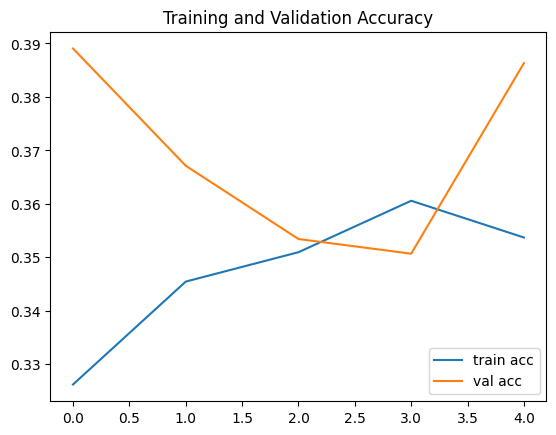

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 967ms/step
                   precision    recall  f1-score   support

          healthy       0.39      0.52      0.45       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.00      0.00      0.00       125
             scab       0.38      0.72      0.50       119

         accuracy                           0.38       365
        macro avg       0.19      0.31      0.24       365
     weighted avg       0.23      0.38      0.29       365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Classification report
val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


# Check Model on Data Pics

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: healthy


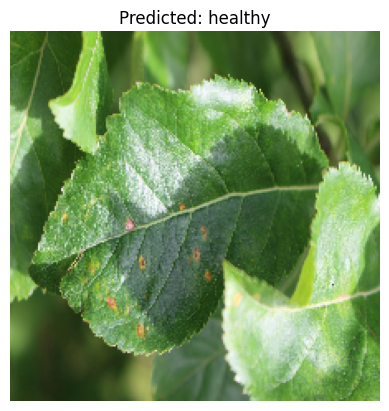

In [16]:
# Load and predict one test image
from tensorflow.keras.preprocessing import image

test_img_path = '/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1.jpg'
img = image.load_img(test_img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_label = list(train_gen.class_indices.keys())[np.argmax(pred)]
print("Predicted label:", pred_label)

plt.imshow(img)
plt.title(f"Predicted: {pred_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


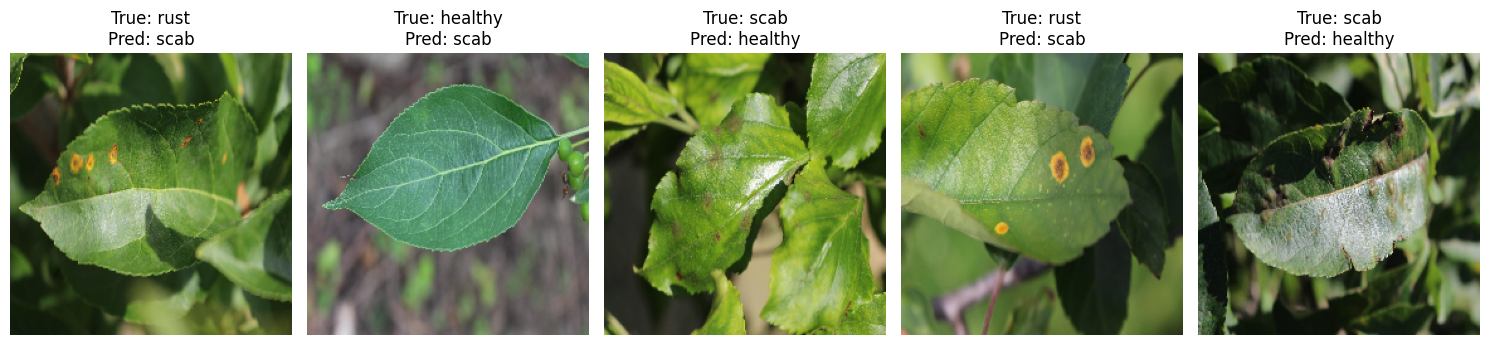

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

sample_df = df.sample(5)

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample_df.itertuples(), 1):
    img_path = f"/kaggle/input/plant-pathology-2020-fgvc7/images/{row.image_id}"
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array)
    pred_label = list(train_gen.class_indices.keys())[np.argmax(pred)]
    
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"True: {row.label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Check Model on Google Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


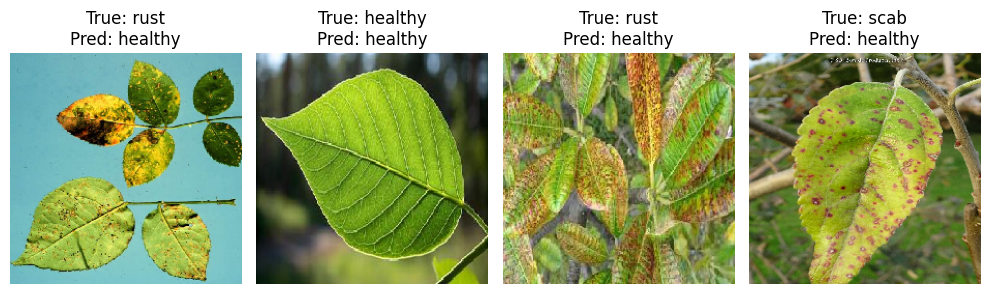

In [22]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Image size used during training
img_size = 224

# List of tuples: (image_path, true_label)
test_images = [
    ('/kaggle/input/images/Rose-rust.jpg', 'rust'),
    ('/kaggle/input/images/healthy.jpg', 'healthy'),
    ('/kaggle/input/images/rust.jpg','rust'),
    ('/kaggle/input/images/scab_large.jpg','scab')
]

# Plotting
plt.figure(figsize=(10, 5))

for i, (img_path, true_label) in enumerate(test_images):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    pred_label = list(train_gen.class_indices.keys())[np.argmax(pred)]

    # Plot image with true and predicted labels
    plt.subplot(1, len(test_images), i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
